In [51]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy
import pandas
import scipy.stats
import sklearn
import sklearn.cluster
import sklearn.preprocessing
import utils

%matplotlib inline

In [60]:
# set plot defaults
plt.rcParams['figure.figsize'] = [16, 5]
plt.style.use('bmh')

In [16]:
# read sampled data file
data_file = "longleaf_job_data_fy2018_res_detailed.csv"
n = 1000  # every N line, or random select of 1 / nth the size
df = utils.read_sampled_file(data_file, N=n, random_sampling=True)

,id_job,id_user,cpus_req,mem_req,nodes_alloc,partition,timelimit,time_submit,time_start,time_end,max_pages,max_rss,max_vsize,max_disk_read,max_disk_write
0,6963525,45180,1,9223372036854777856,1,general,60,1498883008,1498883026,1498883515,0,351912,1000876,224.086868,0.796990
1,6964694,45180,1,9223372036854777856,1,general,60,1498883285,1498883290,1498883346,0,221008,864036,6.834779,0.293135
2,6965253,45180,1,9223372036854777856,1,general,60,1498884397,1498884409,1498884567,0,596316,1240540,141.631187,0.527251
3,6965529,45180,1,9223372036854777856,1,general,60,1498884397,1498884409,1498884429,0,1152,224320,0.000000,0.000000
4,6966164,45180,1,9223372036854777856,1,general,60,1498884788,1498884790,1498884806,0,1124,157756,0.000000,0.000000


In [17]:
# Clean data & add new features
df['mem_req_mod'] = df['mem_req'].apply(lambda x: x - 9223372036854775808 if x > 9223372036854775808 else (x - 2147483648 if x > 2147483648 else x))
df['mem_req_mod'] = df['mem_req_mod'] / 1024

df['cpus_per_node'] = df['cpus_req'] / df['nodes_alloc']
df = df[df['cpus_per_node'] <= 56]

df['timelimit_hrs'] = df['timelimit'] / 60

df = df[df['mem_req_mod'] <= 3000]
df = df[df['time_start'] > 0]
df = df[(df['time_end'] - df['time_start']) > 4]

df['pend_time_hrs'] = (df['time_start'] - df['time_submit']) / 3600
df['run_time_hrs'] = (df['time_end'] - df['time_start']) / 3600

df['max_rss_gb'] = df['max_rss'] / 1024 /1024
df['max_vsize_gb'] = df['max_vsize'] / 1024 /1024

df['total_mem'] = df['max_rss_gb'] + df['max_vsize_gb']

df = df.groupby('id_job').max().reset_index()

In [18]:
# focus on general partition
general_df = df.where(df['partition'] == 'general').dropna()

# remove unnecessary features
features = ['cpus_per_node', 'mem_req_mod', 'timelimit_hrs', 'pend_time_hrs', 'run_time_hrs', 'max_rss_gb', 'max_vsize_gb', 'total_mem']
general_df = general_df[features + ['id_user']]
del(df)

In [47]:
general_df['mem_diff'] = general_df['mem_req_mod'] - general_df['total_mem']
general_df[['mem_req_mod', 'total_mem']].describe()

,mem_req_mod,total_mem
count,18585.000000,18585.000000
mean,7.117697,0.493484
std,16.440623,2.277281
min,0.004883,0.000000
25%,2.000000,0.135799
50%,4.687500,0.144863
75%,5.000000,0.286701
max,227.000000,120.821789


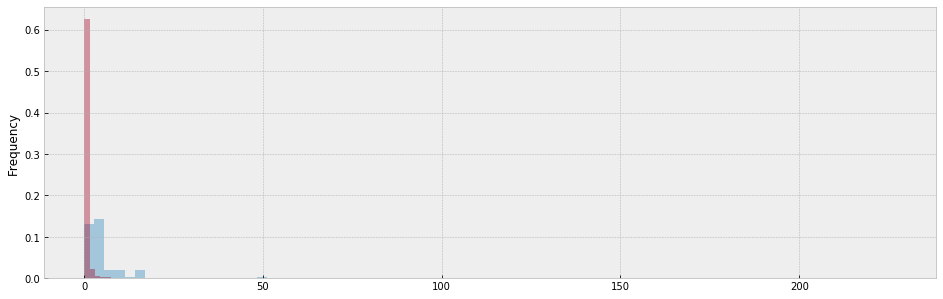

In [61]:
general_df['mem_req_mod'].plot(kind='hist', bins=80, density=True, alpha=.4)
general_df['total_mem'].plot(kind='hist', bins=80, density=True, alpha=.4);

In [62]:
scaled_values = sklearn.preprocessing.StandardScaler().fit_transform(general_df.values)
scaled_df = pandas.DataFrame(data=scaled_values, columns=general_df.columns)

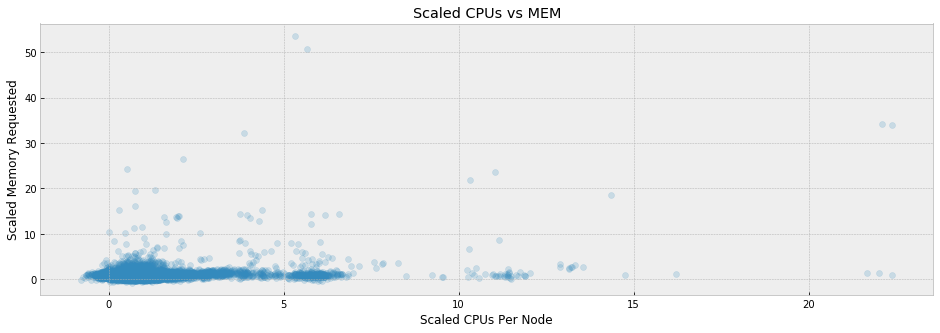

In [63]:
plt.scatter(utils.add_jitter(scaled_df['cpus_per_node']), utils.add_jitter(scaled_df['total_mem']), alpha=.2)
plt.xlabel('Scaled CPUs Per Node')
plt.ylabel('Scaled Memory Requested')
plt.title('Scaled CPUs vs MEM');

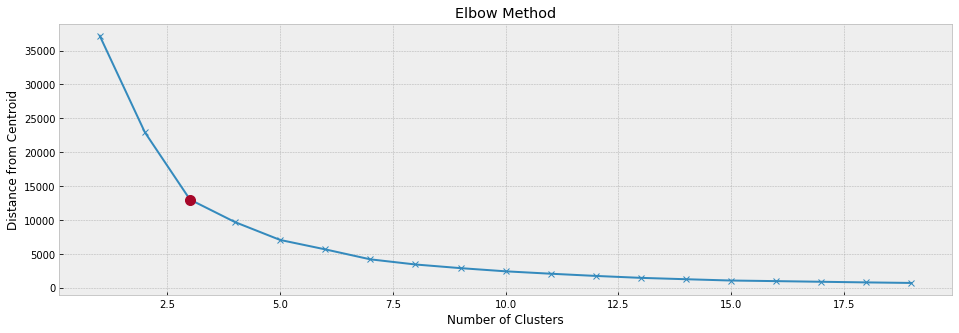

In [64]:
Nc = 20
scaled_X = numpy.array(list(zip(scaled_df['cpus_per_node'], scaled_df['total_mem'])))
elbow_data = utils.elbow_method(scaled_X, num_clusters=Nc)

plt.plot(range(1, Nc), elbow_data, 'x-')
plt.plot(3, elbow_data[2], 'o', markersize=10)
plt.xlabel('Number of Clusters')
plt.ylabel('Distance from Centroid')
plt.title('Elbow Method');

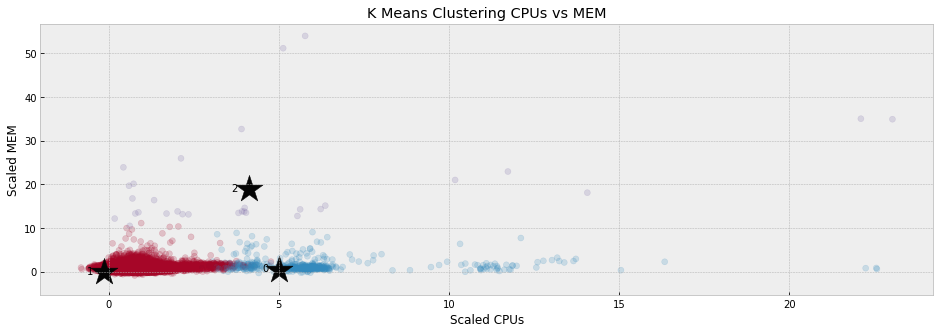

In [65]:
number_of_clusters = 3
labels, centroids = utils.kmeans_cluster(scaled_X, number_of_clusters)

colormap = dict([(i,e) for i,e in enumerate(plt.rcParams['axes.prop_cycle'].by_key()['color'])])
colors = [colormap.get(l) for l in labels]

plt.scatter(utils.add_jitter(scaled_df['cpus_per_node']), utils.add_jitter(scaled_df['total_mem']), alpha=.2, c=colors)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#050505', s=800)
plt.xlabel('Scaled CPUs')
plt.ylabel('Scaled MEM')
plt.title('K Means Clustering CPUs vs MEM');

for i,c in enumerate(centroids):
    plt.annotate(i, (centroids[i,0]-0.5, centroids[i,1]-0.5))

In [73]:
general_df['labels'] = labels
categories = general_df.groupby('labels')
categories[['cpus_per_node', 'total_mem']].describe()

cpus_per_node                                                    \
               count       mean        std  min  25%   50%   75%   max   
labels                                                                   
0              479.0  12.356994   5.506929  6.0  8.0  12.0  12.0  48.0   
1            18075.0   1.126080   0.671726  1.0  1.0   1.0   1.0   6.0   
2               31.0  10.419355  12.309276  1.0  2.0   8.0  12.0  48.0   

       total_mem                                                         \
           count       mean        std        min        25%        50%   
labels                                                                    
0          479.0   1.557238   3.125753   0.102905   0.102905   0.272182   
1        18075.0   0.391250   0.908497   0.000000   0.135799   0.144863   
2           31.0  43.665463  24.684381  24.294323  28.816435  31.536533   

                               
              75%         max  
labels                         
0        1.571609   18.561413  
1        0.263847   22.544827  
2       49.730810  120.821789

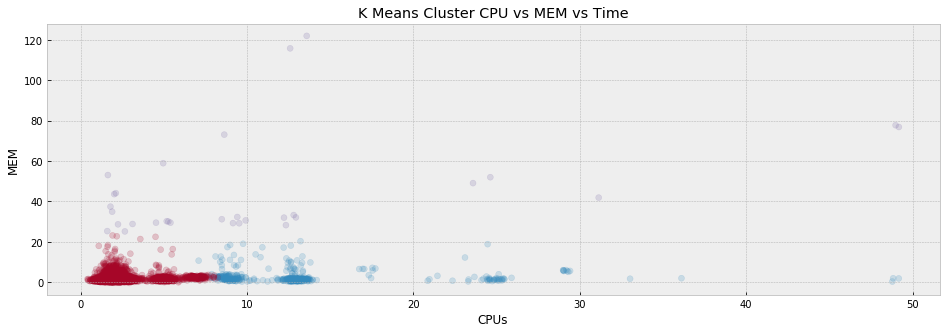

In [71]:
plt.scatter(utils.add_jitter(general_df['cpus_per_node']), utils.add_jitter(general_df['total_mem']), alpha=.2, c=colors)
plt.xlabel('CPUs')
plt.ylabel('MEM')
plt.title('K Means Cluster CPU vs MEM vs Time');

In [72]:
job_count = categories.describe()['cpus_per_node']['count']
unique_users = categories['id_user'].nunique()
for i,c in job_count.items():
    print("Category %d: %10.2f percent of jobs" % (i, c/sum(job_count)*100))
print()
for i,c in unique_users.items():
    print("Category %d: %10.2f percent of users" % (i, c/general_df['id_user'].nunique()*100))

Category 0:       2.58 percent of jobs
Category 1:      97.26 percent of jobs
Category 2:       0.17 percent of jobs

Category 0:      21.00 percent of users
Category 1:      93.00 percent of users
Category 2:       7.33 percent of users


In [94]:
a = general_df.groupby('id_user').describe()['mem_diff'].sort_values('mean')                                                            

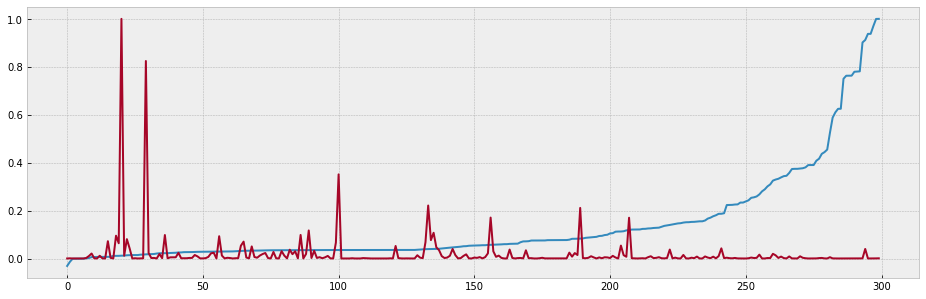

In [100]:
plt.plot(a['mean'].values/max(a['mean'].values))
plt.plot(a['count'].values/max(a['count'].values))

In [122]:
## Could look at recent user submissions and compare mem_diff to the rest of the population and notify when over allocate
## how will training users affect paritions? Will want strategy for modifying number of resources in each partition
high = a[a['mean']> a['mean'].quantile(q=.75)]